In [1]:
import sys
sys.path.append('../../src')

In [2]:
import pandas as pd
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource, Scope
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min
from scipy import stats

In [3]:
# To solve the scheduling level problem for the motivating example of 3 forms of LNG production with varying GWP (resets every year), varying ERCOT power prices & NG prices (fluctuates every hour for the next 5 years)
# For optimal cost vs emission scenario (and varying weights for emission reduction , eg, for 10% reduction in emission, what is the best case scenario)

In [4]:
horizon = 1
scales = TemporalScale(discretization_list=[1,1825])

In [5]:
bigM = 10**8
smallM = 0.001

In [6]:
import pandas as pd

# Read the Excel file into a DataFrame
elec_price_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/AICHE/AICHE 2025 Data/Complete_ERCOT_Prices - 5 year_Daily.csv')


elec_price_df

# Increment index by 1 (optional, depending on what you want to do)
# elec_price_df.index = elec_price_df.index + 1

# Display DataFrame
# print(elec_price_df)

# Get the maximum price from the first column


,Settlement Point Price
0,14.70
1,18.45
2,17.73
3,13.60
4,16.14
...,...
1820,17.11
1821,22.73
1822,12.23
1823,16.13


In [7]:
#The natural gas price is calculated as the average between the high and low cost, also the unit used is $/kg of natural gas
GWP_df = pd.read_csv(r"C:/Users/marcopdsousa/Documents/energiapy/AICHE/AICHE 2025 Data/GWP_FuelMix.csv")
# NG_price_df = pd.DataFrame(NG_price_df['USD/kg'])[::-1].reset_index()
GWP_df = GWP_df[['Methane']]
GWP_df = GWP_df[:1825].reset_index(drop = True)
GWP_df

,Methane
0,83.82
1,83.82
2,83.82
3,83.82
4,83.82
...,...
1820,112.23
1821,112.23
1822,112.23
1823,112.23


In [8]:
#The natural gas price is calculated as the average between the high and low cost, also the unit used is $/kg of natural gas
TVEF_df = pd.read_csv(r"C:/Users/marcopdsousa/Documents/energiapy/AICHE/AICHE 2025 Data/GWP_FuelMix.csv")
# NG_price_df = pd.DataFrame(NG_price_df['USD/kg'])[::-1].reset_index()
TVEF_df = TVEF_df[['GWP']]
TVEF_df = TVEF_df[:1825].reset_index(drop = True)
TVEF_df

,GWP
0,276.211933
1,332.332728
2,324.429326
3,353.487385
4,302.086112
...,...
1820,315.482312
1821,315.482312
1822,315.482312
1823,315.482312


In [9]:
TVEF_value = TVEF_df.max()[0]
GWP_value = GWP_df.max()[0]
elec_price = elec_price_df.max()[0]

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_35520\1306193089.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  TVEF_value = TVEF_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_35520\1306193089.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  GWP_value = GWP_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_35520\1306193089.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_

In [10]:
# Formula verified

#for index in elec_price_df.index:
    #if index <= 20:
        #GWP_value = 112.23
    #elif index <= 70:
        #GWP_value = 99.99
    #elif index <= 72:
        #GWP_value = 92.84
    #else:
        #GWP_value = 83.82
    
    #print(f"Index: {index}, GWP_value: {GWP_value}")  # To check the values dynamically


In [11]:
# for index in elec_price_df.index:
#     if index <= 365:
#         GWP_value = 112.23
#     elif index >365 and index<= 730:
#         GWP_value = 99.99
#     elif index >730 and index<= 1095:
#         GWP_value = 92.84
#     elif index >1095 and index<= 1460:
#         GWP_value = 87.76
#     else:
#         GWP_value= 83.82
#         # for 5 years
#         # 112.23

In [12]:
# Natural gas great alternative to Coal

In [13]:
# Outputs

CO2 = Resource(name='CO2 Vented from the process', basis='kg/hr',
               label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True, scope = Scope.ONE)

Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               label='Methane from the process', block='Resource', cons_max = bigM, gwp = GWP_value, varying = [VaryingResource.DETERMINISTIC_GWP], scope = Scope.ONE)

#cons_max=bigM, GWP_value, varying = [VaryingResource.DETERMINISTIC_GWP]

MethaneD = Resource(name='Dynamic Methane emission', basis='kg', label='Methane emitted')

NGL = Resource(name='Natural Gas Liquids_in_extraction', basis='kg/hr', label='Natural Gas Liquids_in_extraction', block='Resource', sell=True)

ProducedWater = Resource(name='H2O vented from the process',
               basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')

LNG = Resource(name='LNG', demand = True, basis='kg/hr', label='LNG', block='Resource')

Boil_off_LNG = Resource(name='Boil_off_LNG', sell=True, basis='kg/hr', label='Boil_off_LNG', block='Resource')

Heat_Energy = Resource(name='Heat_Energy', basis='MW', label='Heat_Energy', sell=True, block='Resource')

#Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               #label='Methane from the process', block='Resource', gwp = GWP_value, varying = [VaryingResource.DETERMINISTIC_GWP], sell=True, scope = Scope.ONE)

# Inputs

Power = Resource(name='Power', basis='MW', label='Power generated')

GridPower = Resource(name='GridPower', basis='MW',
                     cons_max=bigM, label='Power bought', gwp= TVEF_value, price =elec_price ,varying = [VaryingResource.DETERMINISTIC_PRICE, VaryingResource.DETERMINISTIC_GWP], scope = Scope.TWO)
# Grid Power GWP from average value of time-varying GWP

ResourceWater = Resource(name='H2O',
               basis='kg/hr', cons_max=bigM, label='Water', price = 0.002, block='Resource')

Proppant_Additive = Resource(name='Proppant_Additive', basis='kg/hr', label='Proppant_Additive', block='Resource', price= 0.975, cons_max=bigM)
# Reference Link: https://www.maximizemarketresearch.com/market-report/global-proppant-market/14899/?utm_source=chatgpt.com

Diesel = Resource(name='Diesel', basis='kg/hr', label='Diesel', block='Resource', price= 0.98, cons_max=bigM)
# Reference Link: https://businessanalytiq.com/procurementanalytics/index/diesel-price-index/

Cooling_Water_In_Liquifaction = Resource(name='Cooling_Water_In_Liquifaction', basis='kg/hr', label='Cooling_Water_In_Liquifaction', block='Resource', cons_max=bigM, price= 0.0572)
# Reference link: https://www.intratec.us/products/industry-economics-worldwide/utility/cooling-water-united-states

LNG =  Resource(name='LNG', demand=True, basis='kg/hr', label='LNG', block='Resource')

Glycol = Resource(name='Glycol', basis='kg/hr', label='Glycol', block='Resource', cons_max=bigM, price= 0.052)
# Reference link: https://businessanalytiq.com/procurementanalytics/index/ethylene-glycol-price-index/

MDEA = Resource(name='MDEA', basis='kg/hr', label='MDEA', block='Resource', cons_max=bigM, price= 10)

In [14]:
# FU: 1 kg/hr of LNG
# 3 methane producing processes

Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='Grid', basis='MW')

MDGWP = Process(name='MDGWP', conversion={Methane: -1, MethaneD: 1}, prod_min=smallM, prod_max=bigM, label='MDGWP', basis='kg')

Conventional_NG = Process(name='Conventional_NG', conversion={Boil_off_LNG: 0.01, Power: -0.0028, ResourceWater: -0.5, Diesel: -0.000741382, Glycol: -0.000818111, MDEA: -0.012391658, Cooling_Water_In_Liquifaction: -1.75,
                                                              MethaneD: -0.00395, CO2: 0.966504505 , NGL: 0.3, Heat_Energy: 0.02, ProducedWater: 0.912, LNG: 1}, capex=0.17, fopex=1.5, vopex=1.5, prod_min=smallM, prod_max=bigM, label='Conventional LNG', basis='kg/hr')  

# https://shareholdersunite.com/the-ioc-files-useful-background-material/the-economics-of-lng/

ShaleGas = Process(name='ShaleGas', conversion={Boil_off_LNG: 0.01, Power: -0.003, ResourceWater: -0.92, Diesel: -0.002041766, Glycol: -0.01875, MDEA: -0.284, Cooling_Water_In_Liquifaction: -2.75,
                                                              MethaneD: -0.00895, CO2: 2.1, NGL: 1.9, Heat_Energy: 0.074, ProducedWater: 2.2205, LNG: 1}, capex=0.19, fopex=0.6, vopex=0.6, prod_min=smallM, prod_max=bigM, label='ShaleGas', basis='kg/hr')
# https://marcelluscoalition.org/wp-content/uploads/2012/07/The-Arithmetic-of-Shale-Gas.pdf

Coalbed = Process(name='Coalbed', conversion={Boil_off_LNG: 0.01, Power: -0.01, Diesel: -0.075, Glycol: -0.026539527, MDEA: -0.401985372, Cooling_Water_In_Liquifaction: -3.25,
                                                              MethaneD: -0.811, CO2: 5.823126126, NGL: 0.062761905, Heat_Energy: 0.002, ProducedWater: 6.2755, LNG: 1}, capex=0.205, fopex=2.24, vopex=1.17, prod_min=smallM, prod_max=bigM, label='CoalBed', basis='kg/hr')


# Conventional_NG = Process(name='Conventional_NG', conversion={Boil_off_LNG: 0.01, Power: -0.00015, ResourceWater: -0.5, Diesel: -0.000741382, Glycol: -0.000818111, MDEA: -0.012391658, Cooling_Water_In_Liquifaction: -19.85645933,
#                                                               MethaneD: -0.025, CO2: 0.179504505, NGL: 0.3, Heat_Energy: 0.02, ProducedWater: 0.912, LNG: 1}, fopex=0.0325, vopex=0.0325, prod_min=0.1, prod_max=bigM, label='Conventional LNG', basis='kg/hr')  

# # https://shareholdersunite.com/the-ioc-files-useful-background-material/the-economics-of-lng/

# ShaleGas = Process(name='ShaleGas', conversion={Boil_off_LNG: 0.01, Power: -0.0003, ResourceWater: -2, Diesel: -0.002041766, Glycol: -0.01875, MDEA: -0.284, Cooling_Water_In_Liquifaction: -19.85645933,
#                                                               MethaneD: -0.0395, CO2: 4.114, NGL: 0.0557, Heat_Energy: 0.074, ProducedWater: 0.00002205, LNG: 1}, fopex=2.24, vopex=1.17, prod_min=0.1, prod_max=bigM, label='ShaleGas', basis='kg/hr')
# # https://marcelluscoalition.org/wp-content/uploads/2012/07/The-Arithmetic-of-Shale-Gas.pdf

# Coalbed = Process(name='Coalbed', conversion={Boil_off_LNG: 0.01, Power: -0.001, Diesel: -0.075, Glycol: -0.026539527, MDEA: -0.401985372, Cooling_Water_In_Liquifaction: -19.85645933,
#                                                               MethaneD: -0.811, CO2: 5.823126126, NGL: 0.062761905, Heat_Energy: 0.002, ProducedWater: 6.2755, LNG: 1}, fopex=0.245, vopex=0.415, prod_min=0.1, prod_max=bigM, label='CoalBed', basis='kg/hr')

# capacity needed? No

In [15]:
process_set = {Grid, MDGWP, Conventional_NG, ShaleGas, Coalbed}

In [21]:
# network scale level is 2, due to indexing issues. However, this shouldn't change the final output as capex is smallM. Fopex will be mentiond in hourly level

houston = Location(name='Houston', processes=process_set,  price_factor={GridPower: elec_price_df}, gwp_factor={Methane:GWP_df, GridPower:TVEF_df},
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, gwp_scale_level = 1)



In [22]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=0, network_scale_level=0,
                    purchase_scale_level = 1, scheduling_scale_level=1, capacity_scale_level=1, gwp_scale_level =1, 
                    label='full_case', demand={houston: {LNG:200000}})

In [23]:
print("Contents of scenario.gwp_dict:", Location.gwp_factor)
#code not reading demand or gwp factor

Contents of scenario.gwp_dict: None


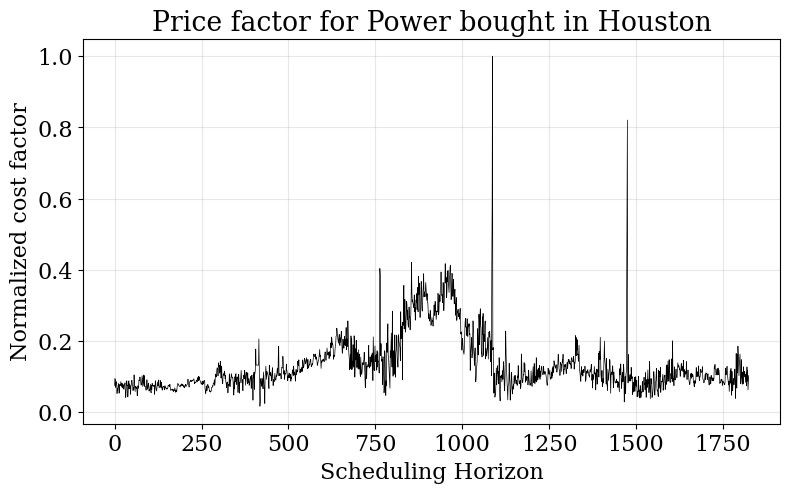

In [24]:
plot_scenario.price_factor(scenario=scenario, location=houston, resource=GridPower, fig_size=(9, 5), color='black')

In [25]:
#, Constraints.MODE

milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.NETWORK,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint storage capex
constraint process incidental
constraint location capex
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [ ]:
# print("Type of scenario.price_dict:", type(scenario.price_dict))
# print("Contents of scenario.price_dict:", scenario.price_dict)

In [ ]:
# type(milp_cost)

In [ ]:
# print("Scale 1 Indices:", list(scales.scale_iter(1)))
# print("Scale 2 Indices:", list(scales.scale_iter(2)))

Ramping constraints

In [26]:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons1.add(expr = milp_cost.P['Houston', 'Conventional_NG', *i] - milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons2.add(milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_cost.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])


In [27]:
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons3.add(expr = milp_cost.P['Houston', 'ShaleGas', *i] - milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons4 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons4.add(milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_cost.P['Houston', 'ShaleGas', *i] <= 0.05*milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])


In [28]:
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons5 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons5.add(expr = milp_cost.P['Houston', 'Coalbed', *i] - milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_cost.cons6 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons6.add(milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_cost.P['Houston', 'Coalbed', *i] <= 0.05*milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])


In [29]:
results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 127842 rows, 668074 columns and 345085 nonzeros
Model fingerprint: 0x7d72c3b9
Variable types: 668069 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+05, 1e+08]
Presolve removed 102287 rows and 657114 columns
Presolve time: 0.08s
Presolved: 25555 rows, 10960 columns, 63883 nonzeros
Variable types: 10953 continuous, 7 integer (5 binary)
Performing another presolve...
Presolve removed 9129 rows and 5479 columns
Presolve time: 0.04s

Root relaxation: objective 3.544021e+05, 1792 iterations, 0.14

In [30]:
results_cost.output['objective']

354402.10967859643

In [31]:
results_cost.output['global_warming_potential_location']

{('Houston', 0): 442151.6355425515}

In [ ]:
4748525.212799198

In [ ]:
results_cost.output['X_P']

In [ ]:
results_cost.output['Cap_P']

In [ ]:
results_cost.output['P']

In [ ]:
results_cost.output['global_warming_potential_resource']

In [ ]:
results_cost.output['global_warming_potential_resource']

In [ ]:
data1 = results_cost.output['P']
df1 = pd.DataFrame(data1,index=[0])
df1 = df1.T
# Export the DataFrame to an Excel file
df1.to_excel('C:\\Users\\marcopdsousa\\Desktop\\AICHE 2025\\Updated_Flow_Test_MinCost_Production Data.xlsx', index=True)

In [ ]:
data2 = results_cost.output['global_warming_potential_resource']
df2 = pd.DataFrame(data2,index=[0])
df2 = df2.T
# Export the DataFrame to an Excel file
df2.to_excel('C:\\Users\\marcopdsousa\\Desktop\\AICHE 2025\\Updated_Flow_MinCost_GWP Data.xlsx', index=True)

In [32]:
#, Constraints.MODE

milp_gwp = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.MIN_GWP, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint storage capex
constraint process incidental
constraint location capex
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
constraint network cost
objective gwp min


In [ ]:
print("Scale 1 Indices:", list(scales.scale_iter(1)))
print("Scale 2 Indices:", list(scales.scale_iter(2)))

In [33]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons1.add(expr = milp_gwp.P['Houston', 'Conventional_NG', *i] - milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons2.add(milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_gwp.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons3.add(expr = milp_gwp.P['Houston', 'ShaleGas', *i] - milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons4 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons4.add(milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_gwp.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons5 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons5.add(expr = milp_gwp.P['Houston', 'Coalbed', *i] - milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons6 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons6.add(milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]] - milp_gwp.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(1)[scales.scale_iter(1).index(i) - 1]])



In [34]:
results_gwp = solve(scenario=scenario, instance=milp_gwp,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 127838 rows, 668069 columns and 345082 nonzeros
Model fingerprint: 0xb05cba38
Coefficient statistics:
  Matrix range     [7e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+08]
Presolve removed 116893 rows and 662594 columns
Presolve time: 0.13s
Presolved: 10945 rows, 5475 columns, 41947 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.205e+04
 Factor NZ  : 1.477e+05 (roughly 8 MB of memory)
 Factor Ops : 2.124e+06 (less than 1 second per iteration)


In [35]:
results_gwp.output['global_warming_potential_location']

{('Houston', 0): 416378.96383391233}

In [36]:
results_gwp.output['Cost']

{None: 490855802.8437262}

In [ ]:
results_gwp.output['Cap_P']

In [ ]:
data = results_gwp.output['global_warming_potential_resource']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel('C:\\Users\\marcopdsousa\\Desktop\\AICHE 2025\\Updated_Flow_Test_MinGWP_ResourceEmission.xlsx', index=True)

In [ ]:
results_gwp.output['global_warming_potential_resource']

In [ ]:
results_cost.output['P_network']

In [ ]:
results_gwp.output['P_network']

In [ ]:
results_gwp.output['Cost']

In [ ]:
data = results_gwp.output['P']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel('C:\\Users\\marcopdsousa\\Desktop\\AICHE 2025\\Updated_Flow_Test_MinGWP_ProductionData.xlsx', index=True)

Emission Restrictions by 10%

In [ ]:
results_cost.output['global_warming_potential_network'][0]

In [ ]:
milp_gwp_10 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from src.energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_10, gwp_reduction_pct = 10, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons1.add(expr = milp_gwp_10.P['Houston', 'Conventional_NG', *i] - milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons2.add(milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons3.add(expr = milp_gwp_10.P['Houston', 'ShaleGas', *i] - milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons4.add(milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons5.add(expr = milp_gwp_10.P['Houston', 'Coalbed', *i] - milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons6.add(milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_10 = solve(scenario=scenario, instance=milp_gwp_10,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


In [ ]:
results_gwp_10.output['objective']

In [ ]:
results_gwp_10.output['global_warming_potential_resource']

In [ ]:
results_gwp_10.output['global_warming_potential_location']

In [ ]:
results_gwp_10.output['B_location']
#What is B,C location?

In [ ]:
# Not sure why
results_gwp_10.output['P']

20% Emission Restrictions

In [ ]:
milp_gwp_20 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_20, gwp_reduction_pct = 20, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons1.add(expr = milp_gwp_20.P['Houston', 'Conventional_NG', *i] - milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons2.add(milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons3.add(expr = milp_gwp_20.P['Houston', 'ShaleGas', *i] - milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons4.add(milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons5.add(expr = milp_gwp_20.P['Houston', 'Coalbed', *i] - milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons6.add(milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])



In [ ]:
results_gwp_20 = solve(scenario=scenario, instance=milp_gwp_20,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


In [ ]:
results_gwp_20.output['objective']

In [ ]:
results_gwp_20.output['Vopex_location']

In [ ]:
results_gwp_20.output['global_warming_potential_location']

In [ ]:
results_gwp_20.output['global_warming_potential_resource']

In [ ]:
results_gwp_20.output['P']

30% emission restrictions

In [ ]:
milp_gwp_30 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_30, gwp_reduction_pct = 30, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons1.add(expr = milp_gwp_30.P['Houston', 'Conventional_NG', *i] - milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons2.add(milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons3.add(expr = milp_gwp_30.P['Houston', 'ShaleGas', *i] - milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons4.add(milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons5.add(expr = milp_gwp_30.P['Houston', 'Coalbed', *i] - milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons6.add(milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_30 = solve(scenario=scenario, instance=milp_gwp_30,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_30.output['objective']

In [ ]:
results_gwp_30.output['P']

In [ ]:
results_gwp_30.output['global_warming_potential_resource']

In [ ]:
results_gwp_30.output['global_warming_potential_location']

40% Emission reduction

In [ ]:
milp_gwp_40 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_40, gwp_reduction_pct = 40, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons1.add(expr = milp_gwp_40.P['Houston', 'Conventional_NG', *i] - milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons2.add(milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons3.add(expr = milp_gwp_40.P['Houston', 'ShaleGas', *i] - milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons4.add(milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_40.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons5.add(expr = milp_gwp_40.P['Houston', 'Coalbed', *i] - milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_40.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons6.add(milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_40.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_40 = solve(scenario=scenario, instance=milp_gwp_40,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_40.output['objective']

In [ ]:
results_gwp_40.output['P']

In [ ]:
results_gwp_40.output['global_warming_potential_resource']

In [ ]:
results_gwp_40.output['global_warming_potential_location']

50% Emission Restriction

In [ ]:
milp_gwp_50 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_50, gwp_reduction_pct = 50, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons1.add(expr = milp_gwp_50.P['Houston', 'Conventional_NG', *i] - milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons2.add(milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_50.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons3.add(expr = milp_gwp_50.P['Houston', 'ShaleGas', *i] - milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons4.add(milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_50.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_50.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons5.add(expr = milp_gwp_50.P['Houston', 'Coalbed', *i] - milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_50.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_50.cons6.add(milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_50.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_50.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_50 = solve(scenario=scenario, instance=milp_gwp_50,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_50.output['objective']

In [ ]:
results_gwp_50.output['P']

In [ ]:
results_gwp_50.output['global_warming_potential_resource']

In [ ]:
results_gwp_50.output['global_warming_potential_location']

60% Emission reduction

In [ ]:
milp_gwp_60 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_60, gwp_reduction_pct = 60, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons1.add(expr = milp_gwp_60.P['Houston', 'Conventional_NG', *i] - milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons2.add(milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_60.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons3.add(expr = milp_gwp_60.P['Houston', 'ShaleGas', *i] - milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons4.add(milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_60.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_60.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons5.add(expr = milp_gwp_60.P['Houston', 'Coalbed', *i] - milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_60.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_60.cons6.add(milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_60.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_60.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_60 = solve(scenario=scenario, instance=milp_gwp_60,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_60.output['objective']

In [ ]:
results_gwp_60.output['P']

In [ ]:
results_gwp_60.output['global_warming_potential_resource']

In [ ]:
results_gwp_60.output['global_warming_potential_location']

70% emission reduction

In [ ]:
milp_gwp_70 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_70, gwp_reduction_pct = 70, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons1.add(expr = milp_gwp_70.P['Houston', 'Conventional_NG', *i] - milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons2.add(milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_70.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons3.add(expr = milp_gwp_70.P['Houston', 'ShaleGas', *i] - milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons4.add(milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_70.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_70.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons5.add(expr = milp_gwp_70.P['Houston', 'Coalbed', *i] - milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_70.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_70.cons6.add(milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_70.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_70.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_70 = solve(scenario=scenario, instance=milp_gwp_70,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_70.output['objective']

In [ ]:
results_gwp_70.output['P']

In [ ]:
results_gwp_70.output['global_warming_potential_resource']

In [ ]:
results_gwp_70.output['global_warming_potential_location']

80% Emission Reduction

In [ ]:
milp_gwp_80 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_80, gwp_reduction_pct = 80, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons1.add(expr = milp_gwp_80.P['Houston', 'Conventional_NG', *i] - milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons2.add(milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_80.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons3.add(expr = milp_gwp_80.P['Houston', 'ShaleGas', *i] - milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons4.add(milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_80.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_80.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons5.add(expr = milp_gwp_80.P['Houston', 'Coalbed', *i] - milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_80.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_80.cons6.add(milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_80.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_80.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_80 = solve(scenario=scenario, instance=milp_gwp_80,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_80.output['objective']

In [ ]:
results_gwp_80.output['P']

In [ ]:
results_gwp_80.output['global_warming_potential_resource']

In [ ]:
results_gwp_80.output['global_warming_potential_location']

90% Emission Reduction

In [ ]:
milp_gwp_90 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_90, gwp_reduction_pct = 90, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons1.add(expr = milp_gwp_90.P['Houston', 'Conventional_NG', *i] - milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons2.add(milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_90.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons3.add(expr = milp_gwp_90.P['Houston', 'ShaleGas', *i] - milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons4.add(milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_90.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_90.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons5.add(expr = milp_gwp_90.P['Houston', 'Coalbed', *i] - milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_90.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_90.cons6.add(milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_90.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_90.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [ ]:
results_gwp_90 = solve(scenario=scenario, instance=milp_gwp_90,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_90.output['objective']

In [ ]:
results_gwp_90.output['P']

In [ ]:
results_gwp_90.output['global_warming_potential_resource']

In [ ]:
results_gwp_90.output['global_warming_potential_location']